In [1]:
import torch

context = []
attn_indices = []
ks = []

for i in range(5):
    state = torch.load(f'../../cache/llama/ensemeble/model_{i}.pth', map_location='cpu')
    if i ==0:
        layer_id = state['layer_id']
        q_timber = state['q_timber']
        k = state['k']
        v = state['v']
        mask_k = state['mask_k']
        block_size_q = state['block_size_q']
        block_size_k = state['block_size_k']
    context.append(state['attn_output_timber'])
    attn_indices.append(state['indices'])
    ks.append(state['ks'])


state = torch.load('../../cache/llama/ensemeble/per_query_token_cnt_diclist.pth', map_location='cpu')
ensemble_attn_mask_per_layer = state['ensemble_attn_mask_per_layer']
per_query_token_cnt_diclist = state['per_query_token_cnt_diclist']

print(q_timber.shape) # N*H, TDST, HID
print(k.shape) # N*H, TSRC, HID
print(v.shape) # N*H, TSRC, HID
print(mask_k)
print(block_size_q)
print(block_size_k)
print(q_timber.shape[1]//block_size_q)
print(mask_k//block_size_k)

print(ensemble_attn_mask_per_layer.shape) # [N_H * TDST//BLOCK_SIZE_Q, mask_k//BLOCK_SIZE_K * 5]
print(per_query_token_cnt_diclist[0])
print(len(per_query_token_cnt_diclist)) # N_H * TDST//BLOCK_SIZE_Q
print(len(ks))
print(ks[0].shape)
print(ks[0])

KeyError: 'layer_id'

In [ ]:
ensemble_attn_mask_per_layer

tensor([[   32,    34,    36,  ...,  2060, 32000, 32000],
        [   16,    18,    20,  ..., 32000, 32000, 32000],
        [   32,    34,    36,  ...,  2096,  2098,  2100],
        ...,
        [ 3492,  3494,  3496,  ...,  4134, 32000, 32000],
        [ 3538,  3540,  3542,  ...,  4166, 32000, 32000],
        [ 3456,  3458,  3460,  ...,  4202,  4204,  4206]], dtype=torch.int32)

In [ ]:
print(per_query_token_cnt_diclist[0])

{32: 5, 34: 5, 36: 5, 38: 5, 40: 5, 42: 5, 44: 5, 46: 5, 96: 5, 98: 5, 100: 5, 102: 5, 112: 5, 114: 5, 116: 5, 118: 5, 120: 5, 122: 5, 124: 5, 126: 5, 128: 5, 130: 5, 132: 5, 134: 5, 184: 2, 186: 2, 188: 5, 190: 5, 192: 5, 194: 5, 196: 5, 198: 5, 200: 3, 202: 3, 208: 1, 210: 1, 212: 3, 214: 3, 216: 5, 218: 5, 220: 5, 222: 5, 224: 5, 226: 5, 228: 3, 230: 3, 244: 5, 246: 5, 248: 5, 250: 5, 266: 5, 268: 5, 298: 3, 300: 3, 302: 5, 304: 5, 306: 5, 308: 5, 310: 3, 312: 3, 322: 5, 324: 5, 326: 5, 328: 5, 378: 5, 380: 5, 382: 5, 384: 5, 402: 5, 404: 5, 406: 5, 408: 5, 410: 2, 412: 2, 414: 2, 416: 2, 422: 5, 424: 5, 426: 5, 428: 5, 466: 5, 468: 5, 470: 5, 472: 5, 482: 1, 484: 1, 486: 4, 488: 4, 490: 4, 492: 4, 494: 1, 496: 1, 572: 5, 574: 5, 576: 5, 578: 5, 580: 5, 582: 5, 584: 5, 586: 5, 588: 5, 590: 5, 592: 5, 594: 5, 636: 5, 638: 5, 640: 5, 642: 5, 692: 3, 694: 3, 696: 5, 698: 5, 700: 4, 702: 4, 704: 4, 706: 4, 708: 2, 710: 2, 716: 2, 718: 2, 720: 2, 722: 2, 774: 5, 776: 5, 778: 5, 780: 5, 7

In [ ]:
N_H, TDST, HID = q_timber.shape
_, TSRC, _ = k.shape
q_k_map = torch.zeros(N_H, TDST//block_size_q, TSRC) # CHECK block_size_q, block_size_k effect 고려해야?
assert q_k_map.shape[1]*N_H == len(per_query_token_cnt_diclist)
q_k_map = q_k_map.view(-1, q_k_map.shape[-1])
print(q_k_map.shape)

torch.Size([5120, 4096])


In [ ]:
print(per_query_token_cnt_diclist[0])

{32: 5, 34: 5, 36: 5, 38: 5, 40: 5, 42: 5, 44: 5, 46: 5, 96: 5, 98: 5, 100: 5, 102: 5, 112: 5, 114: 5, 116: 5, 118: 5, 120: 5, 122: 5, 124: 5, 126: 5, 128: 5, 130: 5, 132: 5, 134: 5, 184: 2, 186: 2, 188: 5, 190: 5, 192: 5, 194: 5, 196: 5, 198: 5, 200: 3, 202: 3, 208: 1, 210: 1, 212: 3, 214: 3, 216: 5, 218: 5, 220: 5, 222: 5, 224: 5, 226: 5, 228: 3, 230: 3, 244: 5, 246: 5, 248: 5, 250: 5, 266: 5, 268: 5, 298: 3, 300: 3, 302: 5, 304: 5, 306: 5, 308: 5, 310: 3, 312: 3, 322: 5, 324: 5, 326: 5, 328: 5, 378: 5, 380: 5, 382: 5, 384: 5, 402: 5, 404: 5, 406: 5, 408: 5, 410: 2, 412: 2, 414: 2, 416: 2, 422: 5, 424: 5, 426: 5, 428: 5, 466: 5, 468: 5, 470: 5, 472: 5, 482: 1, 484: 1, 486: 4, 488: 4, 490: 4, 492: 4, 494: 1, 496: 1, 572: 5, 574: 5, 576: 5, 578: 5, 580: 5, 582: 5, 584: 5, 586: 5, 588: 5, 590: 5, 592: 5, 594: 5, 636: 5, 638: 5, 640: 5, 642: 5, 692: 3, 694: 3, 696: 5, 698: 5, 700: 4, 702: 4, 704: 4, 706: 4, 708: 2, 710: 2, 716: 2, 718: 2, 720: 2, 722: 2, 774: 5, 776: 5, 778: 5, 780: 5, 7

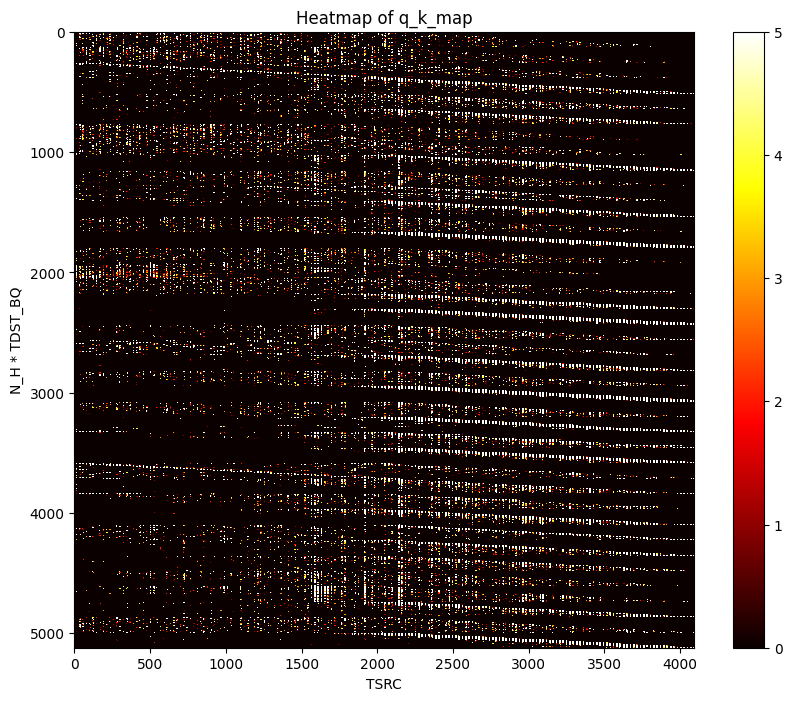

In [ ]:
import matplotlib.pyplot as plt

# per_query_token_cnt_diclist : len 5120 ( N_H*TDST//block_size_q ), each element is a dictionary
# ks : len 5, each having (N_H, TDST//block_size_q)


# Fill the tensor with counts from per_query_token_cnt_diclist
for i, dct in enumerate(per_query_token_cnt_diclist): # i : 5120 -> N_H * TDST//block_size_q
    for idx, count in dct.items():
        if idx >= TSRC:
            continue
        q_k_map[i, idx] = count

# Visualization
plt.figure(figsize=(10, 8))
plt.imshow(q_k_map, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Heatmap of q_k_map')
plt.xlabel('TSRC')
plt.ylabel('N_H * TDST_BQ')
plt.show()

In [ ]:
per_query_token_cnt_diclist[0]

{32: 5,
 34: 5,
 36: 5,
 38: 5,
 40: 5,
 42: 5,
 44: 5,
 46: 5,
 96: 5,
 98: 5,
 100: 5,
 102: 5,
 112: 5,
 114: 5,
 116: 5,
 118: 5,
 120: 5,
 122: 5,
 124: 5,
 126: 5,
 128: 5,
 130: 5,
 132: 5,
 134: 5,
 184: 2,
 186: 2,
 188: 5,
 190: 5,
 192: 5,
 194: 5,
 196: 5,
 198: 5,
 200: 3,
 202: 3,
 208: 1,
 210: 1,
 212: 3,
 214: 3,
 216: 5,
 218: 5,
 220: 5,
 222: 5,
 224: 5,
 226: 5,
 228: 3,
 230: 3,
 244: 5,
 246: 5,
 248: 5,
 250: 5,
 266: 5,
 268: 5,
 298: 3,
 300: 3,
 302: 5,
 304: 5,
 306: 5,
 308: 5,
 310: 3,
 312: 3,
 322: 5,
 324: 5,
 326: 5,
 328: 5,
 378: 5,
 380: 5,
 382: 5,
 384: 5,
 402: 5,
 404: 5,
 406: 5,
 408: 5,
 410: 2,
 412: 2,
 414: 2,
 416: 2,
 422: 5,
 424: 5,
 426: 5,
 428: 5,
 466: 5,
 468: 5,
 470: 5,
 472: 5,
 482: 1,
 484: 1,
 486: 4,
 488: 4,
 490: 4,
 492: 4,
 494: 1,
 496: 1,
 572: 5,
 574: 5,
 576: 5,
 578: 5,
 580: 5,
 582: 5,
 584: 5,
 586: 5,
 588: 5,
 590: 5,
 592: 5,
 594: 5,
 636: 5,
 638: 5,
 640: 5,
 642: 5,
 692: 3,
 694: 3,
 696: 5,
 698: 5,
 7

In [ ]:
len(per_query_token_cnt_diclist)

5120

In [ ]:
a = [1,2,3,4,5,6,7]

for i, p in enumerate(a,4):
    print(i)

4
5
6
7
8
9
10


In [ ]:
len(per_query_token_cnt_diclist) # N_H * TDST//block_size_q

per_query_token_cnt_diclist = [per_query_token_cnt_diclist[i:i+(TDST//block_size_q)] for i in range(0, len(per_query_token_cnt_diclist), TDST//block_size_q)]

In [ ]:
print(len(per_query_token_cnt_diclist))
len(per_query_token_cnt_diclist[0])
print(per_query_token_cnt_diclist[0][0])
print(per_query_token_cnt_diclist[0])

40
{32: 5, 34: 5, 36: 5, 38: 5, 40: 5, 42: 5, 44: 5, 46: 5, 96: 5, 98: 5, 100: 5, 102: 5, 112: 5, 114: 5, 116: 5, 118: 5, 120: 5, 122: 5, 124: 5, 126: 5, 128: 5, 130: 5, 132: 5, 134: 5, 184: 2, 186: 2, 188: 5, 190: 5, 192: 5, 194: 5, 196: 5, 198: 5, 200: 3, 202: 3, 208: 1, 210: 1, 212: 3, 214: 3, 216: 5, 218: 5, 220: 5, 222: 5, 224: 5, 226: 5, 228: 3, 230: 3, 244: 5, 246: 5, 248: 5, 250: 5, 266: 5, 268: 5, 298: 3, 300: 3, 302: 5, 304: 5, 306: 5, 308: 5, 310: 3, 312: 3, 322: 5, 324: 5, 326: 5, 328: 5, 378: 5, 380: 5, 382: 5, 384: 5, 402: 5, 404: 5, 406: 5, 408: 5, 410: 2, 412: 2, 414: 2, 416: 2, 422: 5, 424: 5, 426: 5, 428: 5, 466: 5, 468: 5, 470: 5, 472: 5, 482: 1, 484: 1, 486: 4, 488: 4, 490: 4, 492: 4, 494: 1, 496: 1, 572: 5, 574: 5, 576: 5, 578: 5, 580: 5, 582: 5, 584: 5, 586: 5, 588: 5, 590: 5, 592: 5, 594: 5, 636: 5, 638: 5, 640: 5, 642: 5, 692: 3, 694: 3, 696: 5, 698: 5, 700: 4, 702: 4, 704: 4, 706: 4, 708: 2, 710: 2, 716: 2, 718: 2, 720: 2, 722: 2, 774: 5, 776: 5, 778: 5, 780: 5

In [ ]:
def plot_q_k_map_h(h: int):
    N = 1
    print(f"N hardcoded to : N={N}")
    q_k_map_h = torch.zeros((TDST//block_size_q, TSRC))

    for i, per_query_cnt in enumerate(per_query_token_cnt_diclist[h]):
        for idx, count in per_query_cnt.items():
            if idx >= TSRC:
                continue
            q_k_map_h[i, idx] = count

    print(q_k_map_h)
    # Visualization
    print(q_k_map_h)
    plt.figure(figsize=(6, 10))
    plt.imshow(q_k_map_h, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(f'# of common token selection btw models : l_{layer_id}_h{N*h}')
    plt.xlabel('TSRC')
    plt.ylabel('TDST_BQ')
    plt.show()

    import os
    # os.makedirs('../../cache/llama/ensemeble/viz/per_head_hm/', exist_ok=True)
    # plt.savefig(f'../../cache/llama/ensemeble/viz/per_head_hm/l{layer_id}_h{h}.png')

In [ ]:
for h in range(N_H):
    plot_q_k_map_h(h)

NameError: name 'N_H' is not defined

In [ ]:
attn_indices[0].shape

torch.Size([40, 128, 256])

In [ ]:
attn_indices[0]

tensor([[[   32,    34,    36,  ...,  2068, 32000, 32000],
         [   16,    18,    20,  ..., 32000, 32000, 32000],
         [   32,    34,    36,  ...,  2084, 32000, 32000],
         ...,
         [   14,    16,    18,  ..., 32000, 32000, 32000],
         [  126,   128,   130,  ..., 32000, 32000, 32000],
         [   16,    18,    20,  ...,  4090,  4092,  4094]],

        [[    0,     2,     4,  ...,  2004, 32000, 32000],
         [    0,     2,     4,  ...,  2024,  2026,  2028],
         [    0,     2,     4,  ..., 32000, 32000, 32000],
         ...,
         [   78,    80,    82,  ..., 32000, 32000, 32000],
         [   78,    80,    82,  ...,  3830, 32000, 32000],
         [   80,    82,    84,  ...,  3650,  3652,  3654]],

        [[    0,     2,     4,  ...,  1940,  1942,  1944],
         [    4,     6,     8,  ...,  1986, 32000, 32000],
         [    0,     2,     4,  ..., 32000, 32000, 32000],
         ...,
         [  130,   132,   134,  ..., 32000, 32000, 32000],
         [